# Decision Tree Notebook


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

In [7]:
# Load dataset
bank_df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\binary\bank_customer_churn\Bank Customer Churn Prediction.csv')

# Display basic info
print(bank_df.info())
print(bank_df.describe())
print(bank_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean 

         customer_id  credit_score country gender           age        tenure  \
count   1.000000e+04  10000.000000   10000  10000  10000.000000  10000.000000   
unique           NaN           NaN       3      2           NaN           NaN   
top              NaN           NaN  France   Male           NaN           NaN   
freq             NaN           NaN    5014   5457           NaN           NaN   
mean    1.569094e+07    650.528800     NaN    NaN     38.921800      5.012800   
std     7.193619e+04     96.653299     NaN    NaN     10.487806      2.892174   
min     1.556570e+07    350.000000     NaN    NaN     18.000000      0.000000   
25%     1.562853e+07    584.000000     NaN    NaN     32.000000      3.000000   
50%     1.569074e+07    652.000000     NaN    NaN     37.000000      5.000000   
75%     1.575323e+07    718.000000     NaN    NaN     44.000000      7.000000   
max     1.581569e+07    850.000000     NaN    NaN     92.000000     10.000000   

              balance  prod

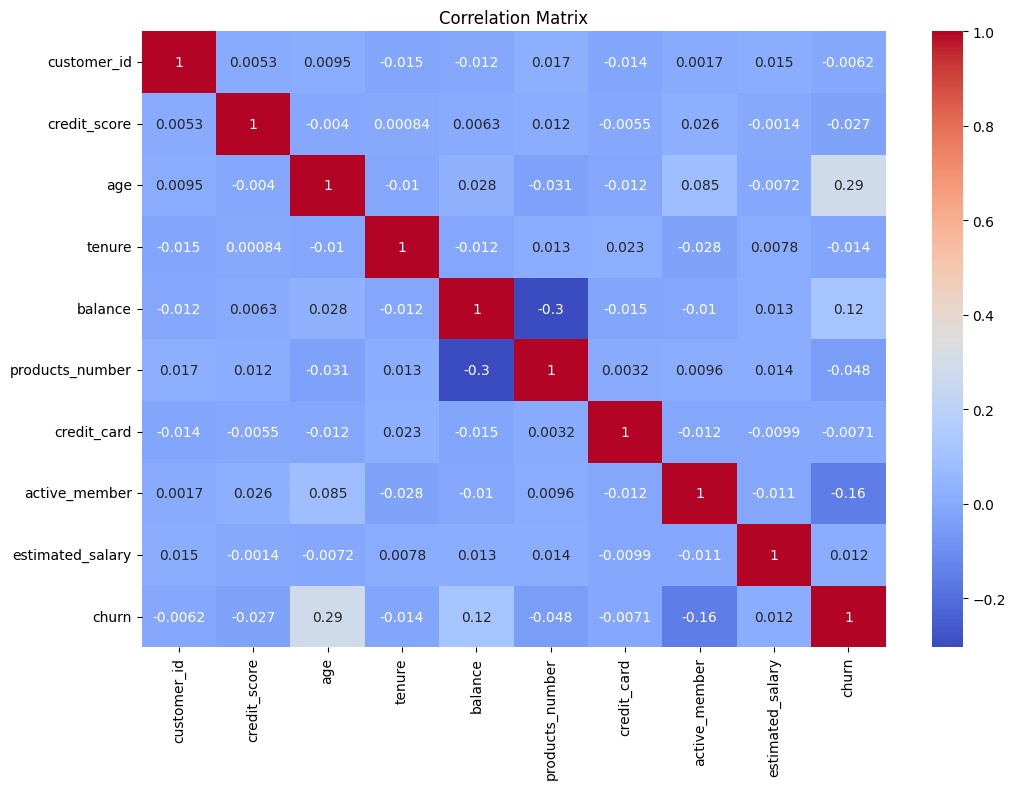

In [8]:
# Display basic statistics
print(bank_df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = bank_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

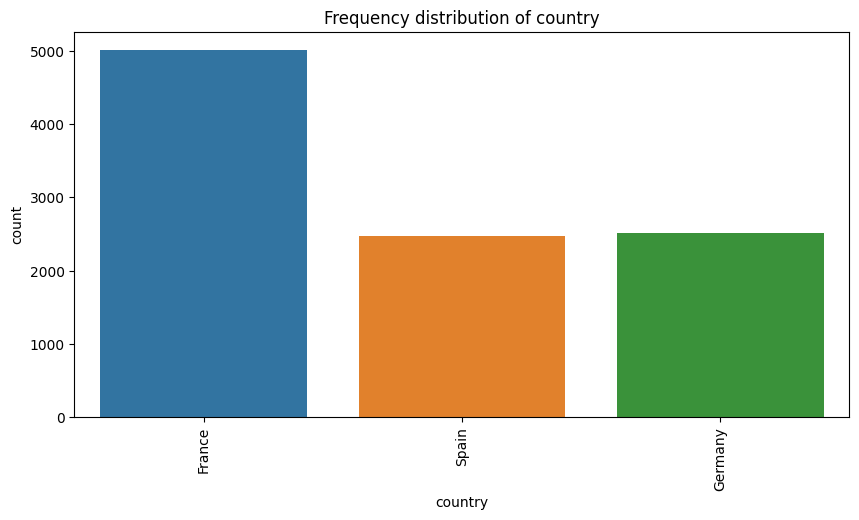

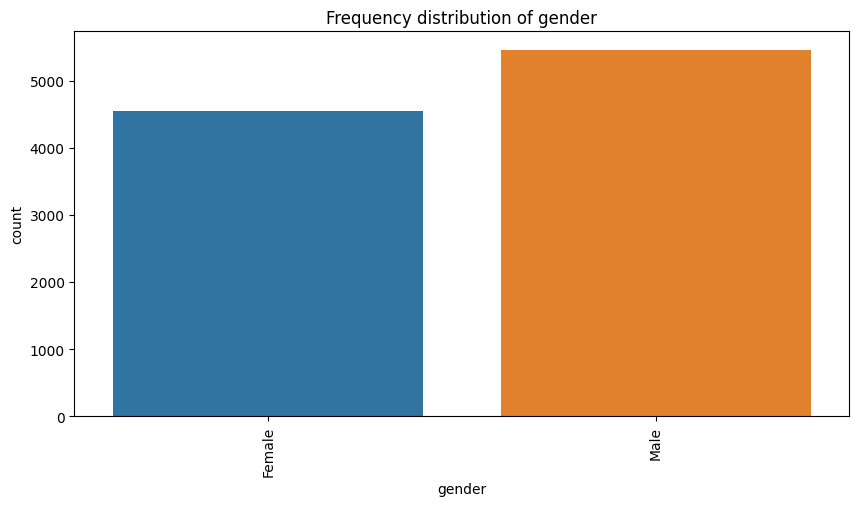

In [9]:
# Frequency distributions for categorical variables
categorical_columns = bank_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=bank_df, x=column)
    plt.title(f'Frequency distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [10]:

# Define the target and features
X = bank_df.drop(columns=['churn'])
y = bank_df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:

# Define the preprocessor
numerical_features = bank_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = bank_df.select_dtypes(include=['object']).columns.tolist()
numerical_features.remove('churn')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the model with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', dt_classifier)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
    return scores.mean()


In [14]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Decision Tree'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)
# Check if the JSON file contains hyperparameters
if 'criterion' in best_params:
    # Use the hyperparameters from the JSON file
    dt_classifier = DecisionTreeClassifier(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    dt_classifier = DecisionTreeClassifier(**best_params)

[I 2025-02-24 19:22:24,095] A new study created in memory with name: no-name-20a285cd-c7d8-40e1-a637-0f50a8801569


Best Hyperparameters: {'model': 'Decision Tree'}


[I 2025-02-24 19:22:26,680] Trial 0 finished with value: 0.8275 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8275.
[I 2025-02-24 19:22:28,340] Trial 1 finished with value: 0.8166249999999999 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8275.
[I 2025-02-24 19:22:30,001] Trial 2 finished with value: 0.820375 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 39, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8275.
[I 2025-02-24 19:22:31,142] Trial 3 finished with value: 0.807 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8275.
[I 2025-02-24 19:22:31,309] Trial 4 finished with value: 0.8026249999999999 and

In [15]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_id',
                                                   'credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'products_number',
                                                   'credit_card',
                                                   'active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'gender'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_leaf=2,
                                        min_samples_split=8))])

In [16]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.8525   0.86875  0.846875 0.85125  0.865   ]
Mean cross-validation score: 0.8568749999999999


In [17]:
# Predict on the test data
y_test_pred = pipeline.predict(X_test)

In [19]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_absolute_error
)
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_pred_encoded = label_encoder.transform(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Regression metrics
r2 = r2_score(y_test_encoded, y_test_pred_encoded)
mae = mean_absolute_error(y_test_encoded, y_test_pred_encoded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


Test Accuracy: 0.8565
Precision: 0.7127659574468085
Recall: 0.49385749385749383
F1 Score: 0.583454281567489
R2 Score: 0.11467708077877581
Mean Absolute Error (MAE): 0.1435


In [20]:
# Generate classification report for the test set
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:\n", test_report)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      1593
           1       0.71      0.49      0.58       407

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



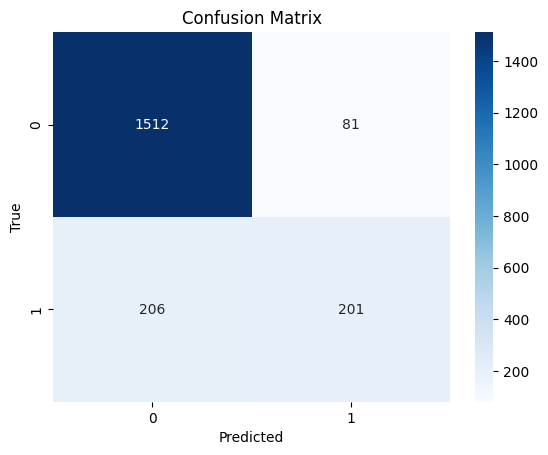

In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

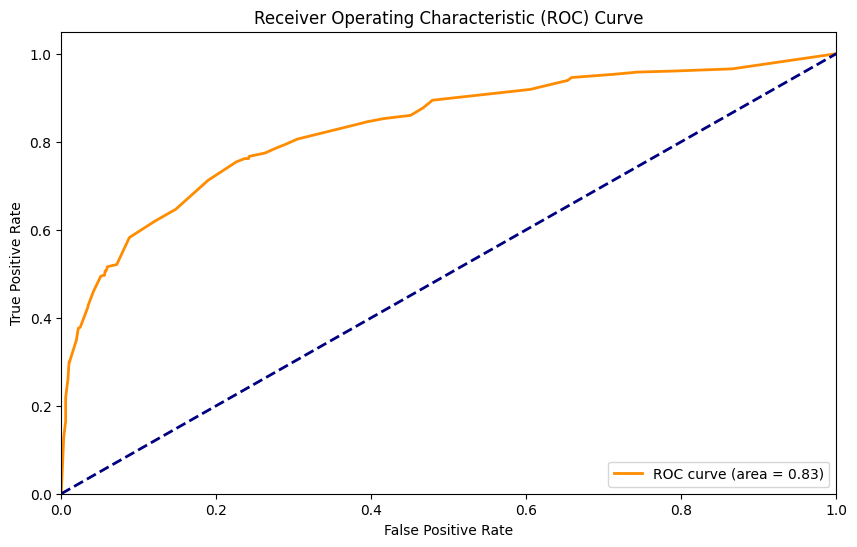

Fidelity: 0.8565


c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


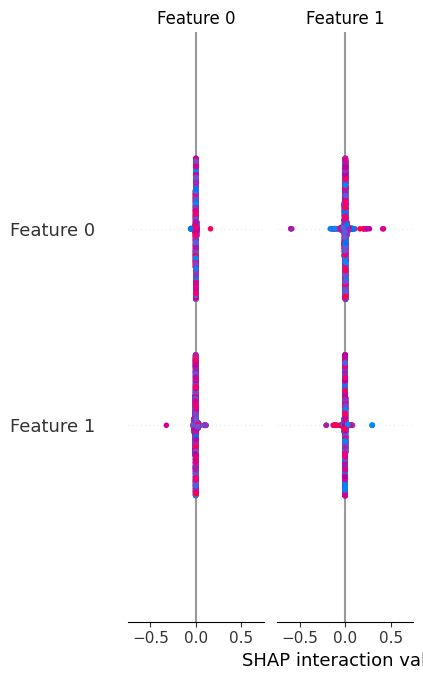

In [23]:

import shap
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_test_transformed)

# Plot ROC-AUC curve
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate fidelity
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)


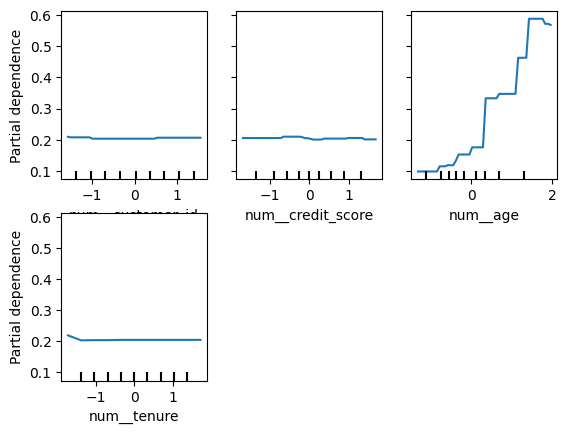

Fidelity: 0.8565


In [24]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select features to analyze (use indices or names)
features = [i for i in range(0, 4)] # Modify based on the features you want to analyze
PartialDependenceDisplay.from_estimator(
    dt_classifier,  # Use the model instead of the pipeline
    X_test_transformed,  # Transformed data
    features=features,
    feature_names=preprocessor.get_feature_names_out(),
    grid_resolution=50
)
plt.show()

# Fidelity remains the same
y_test_pred = pipeline.predict(X_test)
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)


In [25]:
from treeinterpreter import treeinterpreter as ti
import pandas as pd

# Get predictions, biases, and contributions
predictions, biases, contributions = ti.predict(dt_classifier, X_test_transformed)

# Select contributions for the positive class (>50K)
positive_class_index = 1  # Index of the positive class
contributions_positive_class = contributions[:, :, positive_class_index]

# Convert contributions into a DataFrame
feature_names = preprocessor.get_feature_names_out()
contributions_df = pd.DataFrame(contributions_positive_class, columns=feature_names)

# Display contributions for the first instance
instance_index = 0
print(f"Feature contributions for instance {instance_index}:")
print(contributions_df.iloc[instance_index])

# Fidelity remains the same
y_test_pred = pipeline.predict(X_test)
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)


Feature contributions for instance 0:
num__customer_id         0.000000
num__credit_score        0.000000
num__age                -0.085804
num__tenure              0.000000
num__balance            -0.021179
num__products_number    -0.076471
num__credit_card         0.000000
num__active_member       0.000000
num__estimated_salary    0.004125
cat__country_France      0.000000
cat__country_Germany     0.000000
cat__country_Spain       0.000000
cat__gender_Female       0.000000
cat__gender_Male        -0.012678
Name: 0, dtype: float64
Fidelity: 0.8565


In [26]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "Accuracy": test_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC-AUC": roc_auc,
    "Fidelity": fidelity,
    "R2_Score": r2,
    "Mean Absolute Error": mae
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("decision_tree_metrics.csv", index=False)

In [27]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(dt_classifier, 'decision_tree.pkl')

print("Model saved successfully as 'decision_tree.pkl'")


Model saved successfully as 'decision_tree.pkl'
